# The Football Lab: Predicting Player Impact by Position

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [173]:

raw_dataset_23 = pd.read_csv("datasets/2022-2023_Football_Player_Stats.csv", encoding="latin1")
raw_dataset_22 = pd.read_csv("datasets/2021-2022_Football_Player_Stats.csv", encoding="latin1")


## Cleaning & Structuring the Dataset

### Structuring the DataSet
Here in this section we're going to manipulate the dataset. The manipulation are made so it's easier to use it.     
Let's start adding a row with the name of all columns..

In [174]:
## Data Preprocessing
raw_dataset_22.loc[len(raw_dataset_22)] = raw_dataset_22.columns

raw_dataset_22 = raw_dataset_22.iloc[:,0].str.split(";", expand=True)
raw_dataset_22.columns =raw_dataset_22.iloc[len(raw_dataset_22)-1]

raw_dataset_22 = raw_dataset_22.drop(index =len(raw_dataset_22)-1)

raw_dataset_22.head()

2921,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Max Aarons,ENG,DF,Norwich City,Premier League,22,2000,34,32,...,0.03,1.41,1.16,0,0.06,0.03,5.53,0.47,1.59,22.7
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,1987,34,34,...,0,0.06,1.39,0,0.03,0,6.77,2.02,1.36,59.8
2,3,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2000,31,29,...,0,0.36,1.24,0,0,0,8.76,0.88,0.88,50
3,4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,1993,34,34,...,0.03,0.79,2.23,0,0,0,8.87,0.43,0.43,50
4,5,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,2000,1,1,...,0,2,0,0,0,0,4,2,0,100


In [175]:
## Data Preprocessing
raw_dataset_23.loc[len(raw_dataset_23)] = raw_dataset_23.columns

raw_dataset_23 = raw_dataset_23.iloc[:,0].str.split(";", expand=True)
raw_dataset_23.columns =raw_dataset_23.iloc[len(raw_dataset_23)-1]

raw_dataset_23 = raw_dataset_23.drop(index =len(raw_dataset_23)-1)

raw_dataset_23.head()

2689,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,0.17,2.54,0.51,0,0,0,4.86,0.34,1.19,22.2
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,0.05,0.18,1.59,0,0,0,6.64,2.18,1.23,64
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,0,1.05,1.4,0,0,0,8.14,0.93,1.05,47.1
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,0,0.35,0.8,0,0,0.05,6.6,0.5,0.5,50
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,0,0.23,2.02,0,0,0,6.51,0.31,0.39,44.4


Here we are going to delete all the non common columns between the two datasets and the duplicated row.

In [176]:
common_columns = raw_dataset_23.columns.intersection(raw_dataset_22.columns)

raw_dataset_22 = raw_dataset_22[common_columns]
raw_dataset_23 = raw_dataset_23[common_columns]

# Remove duplicates from the dataset
raw_dataset_22 = raw_dataset_22[~raw_dataset_22['Player'].duplicated(keep=False)]

# Remove Javier Llabrés from the datasets because the row in dataset 2021-2022 is incompleted
raw_dataset_22 = raw_dataset_22[raw_dataset_22['Player'] != 'Javier Llabrés']
raw_dataset_23 = raw_dataset_23[raw_dataset_23['Player'] != 'Javier Llabrés']
raw_dataset_22 = raw_dataset_22[raw_dataset_22['Pos'] != 'GKMF']


In this section we choose which columns of datasets that we want keep and which must be converted

In [177]:
columns_to_keep = ["Player", "Nation", "Pos", "Squad", "Comp", "Age", "Min", "MP", "SoT%", "PasTotCmp%", "Goals", "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdY", "CrdR", "Recov"]
columns_to_convert = ["Age", "Min", "MP", "SoT%", "PasTotCmp%", "Goals", "Assists", "TklWon" , "Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdY", "CrdR", "Recov"]

raw_dataset_22["Min"] = raw_dataset_22["Min"].apply(lambda col: pd.to_numeric(col, errors='coerce'))
raw_dataset_23["Min"] = raw_dataset_23["Min"].apply(lambda col: pd.to_numeric(col, errors='coerce'))

column_not_to_norm = ["Player", "Nation", "Pos", "Comp", "Age", "Min", "MP", "SoT%", "PasTotCmp%"]

dataset_22 = raw_dataset_22[columns_to_keep]
dataset_23 = raw_dataset_23[columns_to_keep]

for col in columns_to_convert:
    dataset_22[col] = dataset_22[col].apply(lambda col: pd.to_numeric(col, errors='coerce'))
    dataset_23[col] = dataset_23[col].apply(lambda col: pd.to_numeric(col, errors='coerce'))

for col in columns_to_convert:
    dataset_22.loc[:, col] = pd.to_numeric(dataset_22[col], errors='coerce')
    dataset_23.loc[:, col] = pd.to_numeric(dataset_23[col], errors='coerce')

# verifica valori tra prima e dopo

/tmp/ipykernel_2076/1710157992.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_22[col] = dataset_22[col].apply(lambda col: pd.to_numeric(col, errors='coerce'))
/tmp/ipykernel_2076/1710157992.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_23[col] = dataset_23[col].apply(lambda col: pd.to_numeric(col, errors='coerce'))


In this section we are going to normalize certain columns for the season.

In [178]:
columns_to_normalize = ["Goals", "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdR", "Recov"]

for index, line in dataset_22.iterrows():
    for column in columns_to_normalize:
        dataset_22.at[index, column] = round(dataset_22.at[index, column] * raw_dataset_22.at[index, "Min"] / 90, 0)

columns_to_normalize = [ "Assists", "TklWon" ,"Shots", "SoT", "ShoDist", "ShoPK", "PasTotCmp", "ScaSh", "GCA", "PKatt", "Touches", "PasTotDist", "PasAss", "CrsPA", "ScaPassLive", "Carries", "CarPrgDist", "PPA", "Tkl", "Int", "Clr","BlkSh", "TouDef3rd", "AerWon", "Err", "Fls", "PasLonCmp", "PasLonAtt", "PasDead", "CrdR", "Recov"]

for index, line in dataset_23.iterrows():
    for column in columns_to_normalize:
        dataset_23.at[index, column] = round(dataset_23.at[index, column] * raw_dataset_23.at[index, "Min"] / 90, 0)

dataset_22.head()

2921,Player,Nation,Pos,Squad,Comp,Age,Min,MP,SoT%,PasTotCmp%,...,TouDef3rd,AerWon,Err,Fls,PasLonCmp,PasLonAtt,PasDead,CrdY,CrdR,Recov
0,Max Aarons,ENG,DF,Norwich City,Premier League,22,2881,34,15.4,75.5,...,746.0,15.0,0.0,31.0,98.0,217.0,339.0,0.25,0.0,177.0
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,2983,34,33.3,82.4,...,1087.0,67.0,0.0,43.0,187.0,303.0,100.0,0.15,1.0,224.0
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2462,31,27.8,91.7,...,621.0,24.0,0.0,45.0,184.0,214.0,20.0,0.44,3.0,240.0
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,2956,34,23.3,81.6,...,450.0,14.0,0.0,46.0,205.0,308.0,28.0,0.27,0.0,291.0
4,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,45,1,0.0,33.3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,2.0


In [179]:
dataset_23.head()

2689,Player,Nation,Pos,Squad,Comp,Age,Min,MP,SoT%,PasTotCmp%,...,TouDef3rd,AerWon,Err,Fls,PasLonCmp,PasLonAtt,PasDead,CrdY,CrdR,Recov
0,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,1596,20,18.5,74.9,...,77.0,6.0,1.0,11.0,16.0,42.0,51.0,0.11,0.0,86.0
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1980,22,5.3,81.5,...,605.0,48.0,1.0,29.0,83.0,154.0,82.0,0.09,0.0,146.0
2,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,770,14,33.3,80.8,...,98.0,8.0,0.0,15.0,38.0,51.0,10.0,0.12,0.0,70.0
3,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,1799,20,25.0,91.6,...,240.0,10.0,0.0,49.0,67.0,86.0,28.0,0.15,0.0,132.0
4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1165,15,0.0,87.3,...,249.0,4.0,0.0,12.0,34.0,51.0,10.0,0.16,0.0,84.0


## Visualization part

### Distribution of Minutes Played
### From the chart below, we observe that:

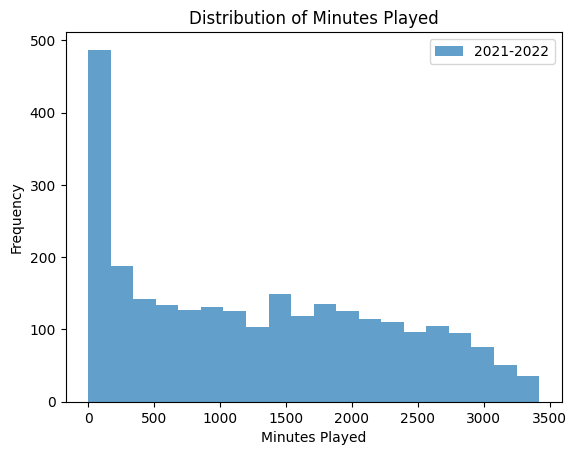

In [180]:
plt.hist(dataset_22["Min"], bins=20, alpha=0.7, label="2021-2022")
plt.xlabel("Minutes Played")
plt.ylabel("Frequency")
plt.title("Distribution of Minutes Played")
plt.legend()
plt.show()

#### Observation:
The highest bar is located on the far left, close to zero. This indicates that a large number of players played a very low number of minutes during the season. This leads to the conclusion that these players are substitutes, debutants, or have suffered injuries. 
After that, a general decrease in the number of players is noticeable as the minutes played increase.

### Boxplot of the Number of Goals by Each Player Based on Position

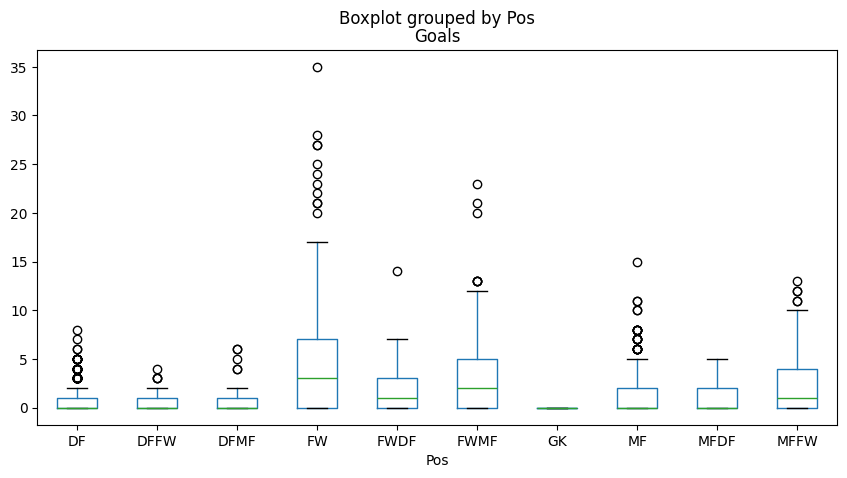

In [181]:
dataset_22.boxplot(column="Goals", by="Pos", grid=False, figsize=(10, 5))
plt.show()

#### In the chart we observe that:

- Forwards (FW) are clearly the position with the highest number of goals scored; in fact, the median is the highest among all roles. Furthermore, for this role, there are very high outlier values, indicating some forwards with a number of goals significantly above the average.

- Attacking midfielders and wingers (FWMF, FWDF, MFFW) tend to score more goals compared to defenders and central midfielders, as expected. Meanwhile, central midfielders and defensive midfielders (MF, MFDF) tend to score fewer goals, and the outliers are less frequent.

- Defenders (DF), including those with more offensive duties (DFFW, DFMF), generally show the lowest number of goals scored; in fact, their medians are very low, close to zero, and the outliers, while present, naturally reach lower values compared to forwards and attacking midfielders.

- Goalkeepers (GK), as expected, almost always score zero goals. A hypothetical outlier would suggest a very rare case of a goal scored by a goalkeeper.

### Boxplot of the Number of Assists Served by Each Player in Various Leagues

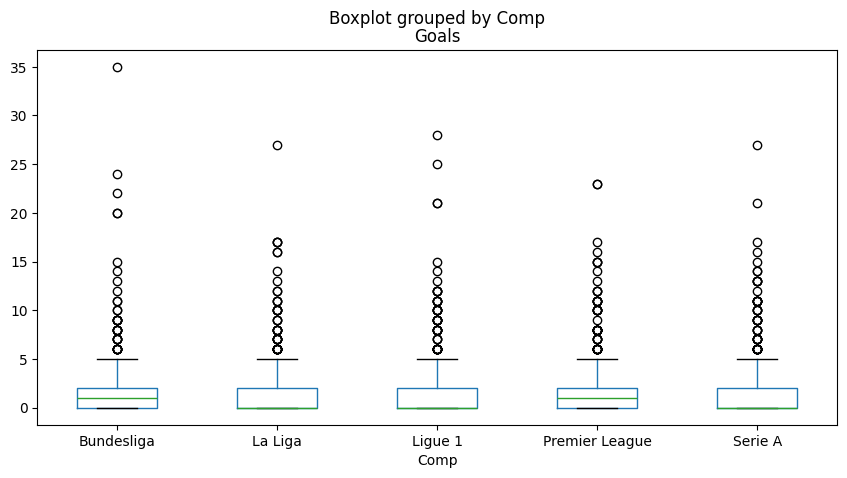

In [182]:
dataset_22.boxplot(column="Goals", by="Comp", grid=False, figsize=(10, 5))
plt.show()

#### In the chart we observe that:
The chart shows that the distributions are similar across the different Comp. Even the number and ditridutions of the outliers is similar for each Comp.        
It's possible to observe that the median of the assist is near 0. The only except is the Premier League that has an little higher median.       
Looking at the outlier ditribution across the Comp it's clear that the League 1 and Bundesliga has got the better assist-men

## OLAP
Here in this section we're going to use an OLAP visualizations of the dataset.      
The OLAP cube'll have three dimentions (Assists, Age, Comp) 

In [183]:
dataset_22_OLAP = dataset_22

In this section we are going to quantize Comp, Age, Assists and Min


In [184]:
quantize_comp = ["Bundesliga", "La Liga", "Ligue 1", "Premier League", "Serie A"]

dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(16,21,'both'),'quantize_age'] = 'YOUNG'
dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(22,27,'both'),'quantize_age'] = 'PROMISE'
dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(28,33,'both'),'quantize_age'] = 'PRIME'
dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(34,41,'both'),'quantize_age'] = 'OLD'
quantize_age = ['YOUNG','PROMISE','PRIME','OLD']

dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(0.0,4.9,'both'),'quantize_assists'] = 'NOTHING'
dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(5.0,9.9,'both'),'quantize_assists'] = 'SOLID'
dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(10.0,14.9,'both'),'quantize_assists'] = 'GOOD'
dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(15.0,19.9,'both'),'quantize_assists'] = 'EXCELLENT'
quantize_assists = ['NOTHING','SOLID','GOOD','EXCELLENT']

dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(0,854,'both'),'quantize_min'] = 'BENCHER'
dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(855,1710,'both'),'quantize_min'] = 'SUB'
dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(1711,2566,'both'),'quantize_min'] = 'STARTER'
dataset_22_OLAP.loc[dataset_22_OLAP['Min'].between(2567,3420,'both'),'quantize_min'] = 'ESSENTIAL'
quantize_min = ['BENCHER','SUB','STARTER','ESSENTIAL']

/tmp/ipykernel_2076/3455102186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_22_OLAP.loc[dataset_22_OLAP['Age'].between(16,21,'both'),'quantize_age'] = 'YOUNG'
/tmp/ipykernel_2076/3455102186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_22_OLAP.loc[dataset_22_OLAP['Assists'].between(0.0,4.9,'both'),'quantize_assists'] = 'NOTHING'
/tmp/ipykernel_2076/3455102186.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

### OLAP visualizations

In [185]:
OLAP_min = np.zeros((4,4,5))
for z in range(0,len(quantize_comp)):
  Awards_prog_z = dataset_22_OLAP[dataset_22_OLAP['Comp'] == quantize_comp[z]]
  for j in range(0,len(quantize_age)):
    for i in range(0,len(quantize_min)):
      OLAP_min[i,j,z] = np.sum((Awards_prog_z['quantize_min'] == quantize_min[i]) & (Awards_prog_z['quantize_age'] == quantize_age[j]))

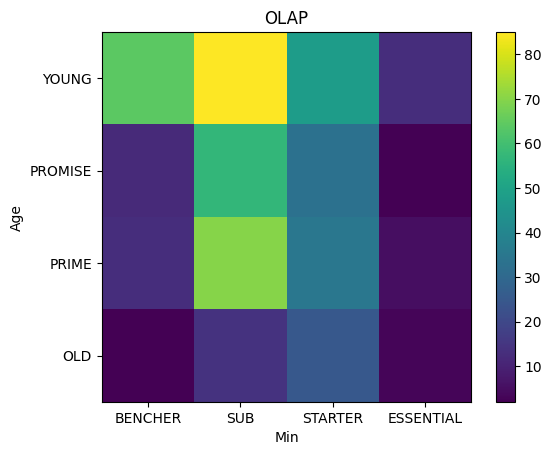

In [186]:
slice_comp = OLAP_min[:,:,0]

plt.ylabel('Age')
plt.xlabel('Min')
plt.imshow(slice_comp)
plt.yticks(ticks=range(len(quantize_age)), labels=quantize_age)
plt.xticks(ticks=range(len(quantize_min)), labels=quantize_min)
plt.colorbar()
plt.title('OLAP')
plt.show()

#### Observations:

In [187]:
OLAP_assists = np.zeros((4,4,5))
for z in range(0,len(quantize_comp)):
  Awards_prog_z = dataset_22_OLAP[dataset_22_OLAP['Comp'] == quantize_comp[z]]
  for j in range(0,len(quantize_age)):
    for i in range(0,len(quantize_assists)):
      OLAP_assists[i,j,z] = np.sum((Awards_prog_z['quantize_assists'] == quantize_assists[i]) & (Awards_prog_z['quantize_age'] == quantize_age[j]))

Slicing on the Comp column (La Liga, Spagna) such that it's possible to show Age e Assists

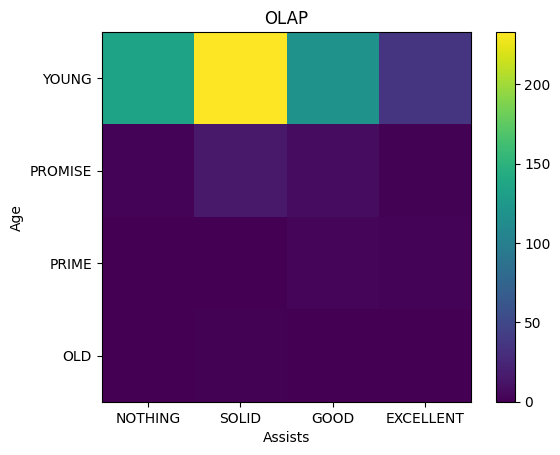

In [188]:
slice_comp = OLAP_assists[:,:,2]

plt.ylabel('Age')
plt.xlabel('Assists')
plt.imshow(slice_comp)
plt.yticks(ticks=range(len(quantize_age)), labels=quantize_age)
plt.xticks(ticks=range(len(quantize_assists)), labels=quantize_assists)
plt.colorbar()
plt.title('OLAP')
plt.show()

#### Observations:
The graph shows that, as we said before, most of the player that served an assists has got between 16 to 21 years of age. In specific as we can see the yellow square is in (YOUNG, SOLID) position which means that more tha 200 player between 16-21 served 5 to 9 assists.       
The OLAP visualization shows that in the other age it's more likely that the player didn't serve much assists.

## Statistical Tests

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

le ipotesi sono verificate, quindi possiamo applicare un t-test a due code.

Scegliamo un livello di significatività di 0.05 (intervallo di confidenza di 0.95).

ipotesi nulla

H0 = la media degli assist in Serie A e la media degli assist in Bundesliga non sono statisticamente diverse;

ipotesi alternativa

HA = Le medie sono diverse.


significatività = 0.05

In [189]:
t_statistic, p_value = stats.ttest_1samp(a= dataset_22['Assists'][dataset_22['Comp']=='Bundesliga'], popmean= dataset_22['Assists'][dataset_22['Comp']=='Serie A'].mean())
print(p_value)
if p_value >= 0.05:
        print("Non possiamo rigettare l'ipotesi nulla")
elif p_value < 0.05:
    # per verificare l'ordine di grandezza
    if 0.05/p_value > 100:
        print("Le medie sono diverse, accetto l'ipotesi alternativa")
    else:
        print("Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa")

0.07929207467328196
Non possiamo rigettare l'ipotesi nulla


in base al risultato del ttest si deduce che non si sa se le due medie sono statisticamente diverse questo perche 
le due medie sono molto vicine tra di loro
percui ora andiamo a verificare piu nello specifico

Scegliamo un livello di significatività di 0.05 (intervallo di confidenza di 0.95).

ipotesi nulla

H0 = la media dei goal in Serie A è inferiore rispetto alla media dei gol in Bundesliga;

ipotesi alternativa

HA = la media dei goal in Serie A non è inferiore rispetto alla media dei gol in Bundesliga.


significatività = 0.05

In [190]:
# ttest ind da usare perché indipendenti
t_statistic, p_value = stats.ttest_1samp(a= dataset_22['Assists'][dataset_22['Comp']=='Bundesliga'], popmean= dataset_22['Assists'][dataset_22['Comp']=='Serie A'].mean(), alternative= 'less')
print(p_value)
if p_value >= 0.05:
        print("Non possiamo rigettare l'ipotesi nulla")
elif p_value < 0.05:
    if 0.05/p_value > 100:
        print("Le medie sono diverse, accetto l'ipotesi alternativa")
    else:
        print("Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa")

0.960353962663359
Non possiamo rigettare l'ipotesi nulla


#### Sanity check

In [191]:
t_statistic, p_value = stats.ttest_1samp(a= dataset_22['Assists'][dataset_22['Comp']=='Bundesliga'], popmean= dataset_22['Assists'][dataset_22['Comp']=='Serie A'].mean(), alternative= 'greater')
print(p_value)
if p_value >= 0.05:
        print("Non possiamo rigettare l'ipotesi nulla")
elif p_value < 0.05:
    if 0.05/p_value > 100:
        print("Le medie sono diverse, accetto l'ipotesi alternativa")
    else:
        print("Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa")

0.03964603733664098
Rigettiamo l'ipotesi nulla ma non possiamo accettare l'ipotesi alternativa


Addestramento AI

ATTACCANTI

In [192]:
position = ['FW', 'FWMF', 'MFFW', 'FWDF']
forwards_data_train = dataset_22[dataset_22['Pos'].isin(position)]
forwards_data_test = dataset_23[dataset_23['Pos'].isin(position)]

features = ['Shots', 'SoT', 'SoT%', 'ShoDist', 'ShoPK', 'PasTotCmp', 'Assists', 'ScaSh', 'GCA', 'PKatt']
target = 'Goals'

X_train = forwards_data_train[features]
y_train = forwards_data_train[target]

X_test = forwards_data_test[features]
y_test = forwards_data_test[target]

striker_pridction = LinearRegression()
striker_pridction.fit(X_train, y_train)

y_pred = striker_pridction.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

In [193]:
comparison_df = forwards_data_test[['Player', 'Goals']].copy()
comparison_df['Predicted Goals'] = y_pred_rounded

# Visualizzare il confronto
#print(comparison_df)

# Esempio: filtrare un giocatore specifico
player_name = "Lionel Messi"  # Sostituisci con il nome del giocatore
player_comparison = comparison_df[comparison_df['Player'] == player_name]
print(player_comparison)

2689        Player  Goals  Predicted Goals
1650  Lionel Messi     10               14


In [194]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.5310536295654764


Text(0.5, 1.0, 'Actual vs Predicted Goals')

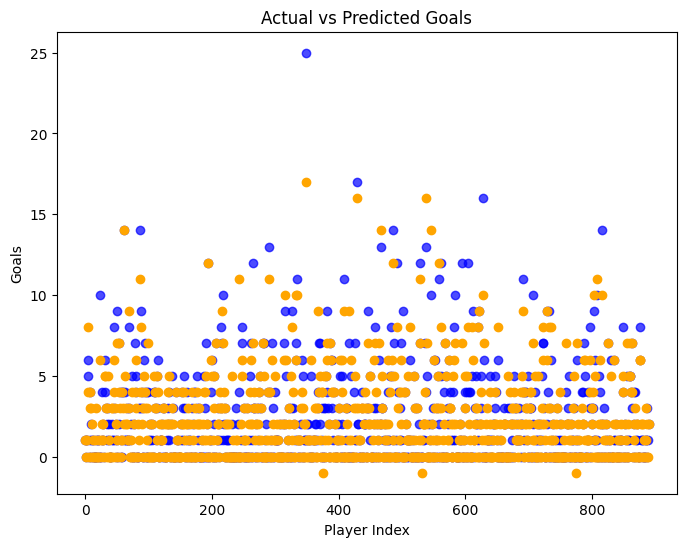

In [195]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Goals', alpha=0.7)

# Gol predetti (y) in arancione
plt.scatter(range(len(y_pred_rounded)), y_pred_rounded, color='orange', label='Predicted Goals')

# Etichette e titolo
plt.xlabel('Player Index')
plt.ylabel('Goals')
plt.title('Actual vs Predicted Goals')

CENTROCAMPISTI

In [196]:
position = ['MF', 'MFDF', 'DFMF', 'MFFW', 'FWMF']
forwards_data_train = dataset_22[dataset_22['Pos'].isin(position)]
forwards_data_test = dataset_23[dataset_23['Pos'].isin(position)]

features = ['PasTotCmp', 'PasTotDist', 'PasAss', 'CrsPA', 'ScaPassLive', 'GCA', 'Carries', 'CarPrgDist', 'PPA']
target = 'Assists'

X_train = forwards_data_train[features]
y_train = forwards_data_train[target]

X_test = forwards_data_test[features]
y_test = forwards_data_test[target]

midfielder_pridction = LinearRegression()
midfielder_pridction.fit(X_train, y_train)

y_pred = midfielder_pridction.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

In [197]:
comparison_df = forwards_data_test[['Player', 'Assists']].copy()
comparison_df['Predicted Assists'] = y_pred_rounded

# Visualizzare il confronto
#print(comparison_df)

# Esempio: filtrare un giocatore specifico
player_name = "Lionel Messi"  # Sostituisci con il nome del giocatore
player_comparison = comparison_df[comparison_df['Player'] == player_name]
print(player_comparison)

2689        Player  Assists  Predicted Assists
1650  Lionel Messi     10.0                 10


In [198]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6142102484976631


Text(0.5, 1.0, 'Actual vs Predicted Assists')

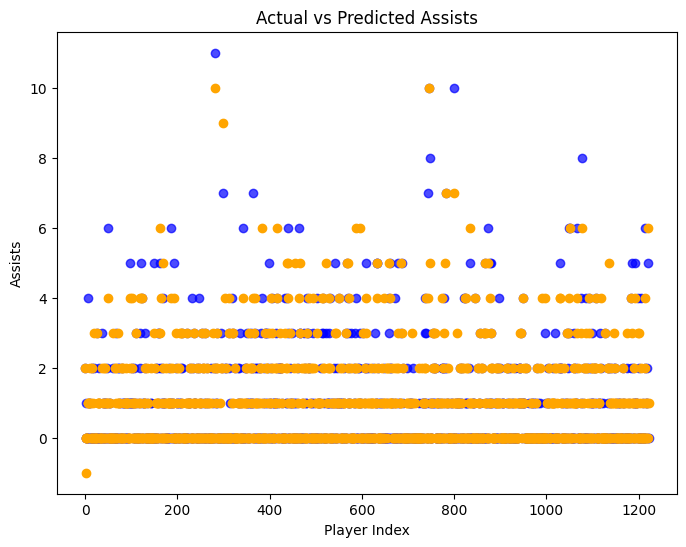

In [199]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Assits', alpha=0.7)

# Gol predetti (y) in arancione
plt.scatter(range(len(y_pred_rounded)), y_pred_rounded, color='orange', label='Predicted Assists')

# Etichette e titolo
plt.xlabel('Player Index')
plt.ylabel('Assists')
plt.title('Actual vs Predicted Assists')